# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 6

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [4]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [5]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [6]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.419
[2] loss: 0.240
[3] loss: 0.072
[4] loss: 0.038
[5] loss: 0.022
[6] loss: 0.017
[7] loss: 0.011
[8] loss: 0.010
[9] loss: 0.010
[10] loss: 0.007
[11] loss: 0.006
[12] loss: 0.008
[13] loss: 0.005
[14] loss: 0.004
[15] loss: 0.005
[16] loss: 0.003
[17] loss: 0.004
[18] loss: 0.003
[19] loss: 0.004
[20] loss: 0.003


In [7]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 6])

In [8]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

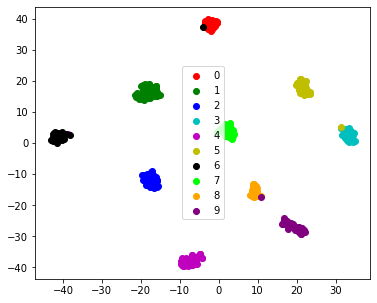

In [9]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

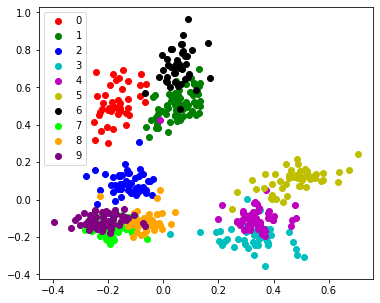

In [10]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [11]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [12]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [13]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1595,  0.0601, -0.1265,  0.3317,  0.3529,  0.4952,  0.0586, -0.1762,
         -0.0751, -0.2276],
        [-0.1709,  0.3621,  0.6181, -0.0647, -0.2427, -0.0119, -0.2121,  0.5214,
         -0.2422, -0.2258],
        [ 0.5144,  0.4902,  0.0686, -0.2067, -0.0896,  0.1221,  0.7101, -0.1489,
         -0.1180, -0.1102],
        [-0.0525, -0.2377,  0.3617, -0.0024, -0.2454, -0.0771,  0.1513, -0.2384,
          0.5424, -0.2100],
        [-0.2652,  0.2465, -0.2058,  0.5677, -0.0416, -0.2569, -0.2293, -0.1626,
          0.0031,  0.4923],
        [ 0.4559, -0.1085, -0.3124, -0.3235,  0.4208, -0.2940, -0.3213,  0.2581,
          0.0887,  0.2295]])

In [14]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [15]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [16]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [18]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_3.cfg')

['./config/sswae_dev2_1_3.cfg']

In [15]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 6
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.353797e-01  D: 6.901693e-01  D2: 4.755431e-02  D3: 3.249481e-03
test loss: 1.780112e-01  D: 6.903740e-01  D2: 1.420274e-02  D3: 6.595185e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.609260e-01  D: 6.941743e-01  D2: 4.996382e-03  D3: 7.871195e-03
test loss: 1.565469e-01  D: 7.178004e-01  D2: 1.754045e-03  D3: 1.096665e-02


[default |INFO|model.py:1280] [03/80]  loss: 1.453013e-01  D: 6.966374e-01  D2: 1.152596e-03  D3: 8.364008e-03
test loss: 1.254473e-01  D: 6.860296e-01  D2: -6.436539e-04  D3: 8.844226e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.152684e-01  D: 6.984466e-01  D2: -1.978436e-03  D3: 1.135260e-02
test loss: 1.507291e-01  D: 6.689692e-01  D2: -1.282959e-03  D3: 1.523927e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.098447e-01  D: 6.896059e-01  D2: -2.335505e-03  D3: 1.595200e-02
test loss: 1.024597e-01  D: 6.934620e-01  D2: -2.396736e-03  D3: 1.442180e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.714985e-02  D: 6.936206e-01  D2: -3.431497e-03  D3: 1.497764e-02
test loss: 9.093116e-02  D: 7.050495e-01  D2: -3.636827e-03  D3: 1.411049e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.955044e-02  D: 6.947864e-01  D2: -4.043617e-03  D3: 1.476850e-02
test loss: 8.519105e-02  D: 6.881510e-01  D2: -4.368753e-03  D3: 1.407992e-02


[default |INFO|model.py:1280] [08/80]  loss: 8.584187e-02  D: 6.955605e-01  D2: -4.516443e-03  D3: 1.255142e-02
test loss: 8.549123e-02  D: 6.952579e-01  D2: -4.644146e-03  D3: 1.519702e-02


[default |INFO|model.py:1280] [09/80]  loss: 8.511408e-02  D: 6.937068e-01  D2: -4.352407e-03  D3: 1.342406e-02
test loss: 8.072523e-02  D: 6.917436e-01  D2: -3.521929e-03  D3: 1.330803e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.842034e-02  D: 6.942954e-01  D2: -4.515909e-03  D3: 1.456614e-02
test loss: 7.627548e-02  D: 6.812664e-01  D2: -5.177355e-03  D3: 1.581882e-02


[default |INFO|model.py:1280] [11/80]  loss: 7.597521e-02  D: 6.933895e-01  D2: -4.723487e-03  D3: 1.480058e-02
test loss: 7.530040e-02  D: 6.993930e-01  D2: -5.138254e-03  D3: 1.188442e-02


[default |INFO|model.py:1280] [12/80]  loss: 7.589958e-02  D: 6.936631e-01  D2: -5.041332e-03  D3: 1.412415e-02
test loss: 7.637564e-02  D: 6.927590e-01  D2: -5.045280e-03  D3: 1.195725e-02


[default |INFO|model.py:1280] [13/80]  loss: 7.561098e-02  D: 6.941012e-01  D2: -5.237851e-03  D3: 1.383809e-02
test loss: 7.339943e-02  D: 6.981856e-01  D2: -5.452862e-03  D3: 1.299032e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.258162e-02  D: 6.931792e-01  D2: -5.210834e-03  D3: 1.449238e-02
test loss: 7.191572e-02  D: 6.837674e-01  D2: -5.505991e-03  D3: 1.564655e-02


[default |INFO|model.py:1280] [15/80]  loss: 7.095742e-02  D: 6.932840e-01  D2: -5.407338e-03  D3: 1.431774e-02
test loss: 7.043183e-02  D: 6.987099e-01  D2: -5.596457e-03  D3: 1.238699e-02


[default |INFO|model.py:1280] [16/80]  loss: 7.090914e-02  D: 6.933616e-01  D2: -5.503737e-03  D3: 1.391414e-02
test loss: 6.952525e-02  D: 6.970454e-01  D2: -6.381407e-03  D3: 1.188326e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.990825e-02  D: 6.936908e-01  D2: -5.815601e-03  D3: 1.390976e-02
test loss: 6.906751e-02  D: 7.088677e-01  D2: -6.091595e-03  D3: 1.570209e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.839364e-02  D: 6.933793e-01  D2: -6.026576e-03  D3: 1.373104e-02
test loss: 6.970097e-02  D: 6.871379e-01  D2: -5.280600e-03  D3: 1.261093e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.847889e-02  D: 6.939396e-01  D2: -6.175472e-03  D3: 1.335112e-02
test loss: 6.796513e-02  D: 6.851582e-01  D2: -5.857353e-03  D3: 1.513189e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.665101e-02  D: 6.932210e-01  D2: -6.128709e-03  D3: 1.383927e-02
test loss: 6.828086e-02  D: 6.903099e-01  D2: -5.272274e-03  D3: 1.301320e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.690336e-02  D: 6.930807e-01  D2: -6.312310e-03  D3: 1.354537e-02
test loss: 6.711325e-02  D: 6.973986e-01  D2: -6.764269e-03  D3: 1.309466e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.747775e-02  D: 6.946287e-01  D2: -6.396429e-03  D3: 1.352384e-02
test loss: 6.787874e-02  D: 6.937538e-01  D2: -6.036787e-03  D3: 1.556690e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.588391e-02  D: 6.927481e-01  D2: -6.569691e-03  D3: 1.358379e-02
test loss: 6.651434e-02  D: 7.011410e-01  D2: -6.820211e-03  D3: 1.485626e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.531967e-02  D: 6.931395e-01  D2: -6.750757e-03  D3: 1.362357e-02
test loss: 6.482943e-02  D: 6.812104e-01  D2: -6.809978e-03  D3: 1.411805e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.492735e-02  D: 6.933071e-01  D2: -6.947336e-03  D3: 1.349575e-02
test loss: 6.977530e-02  D: 6.995974e-01  D2: -6.994610e-03  D3: 1.392396e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.403866e-02  D: 6.937234e-01  D2: -6.948930e-03  D3: 1.349425e-02
test loss: 6.499260e-02  D: 7.013851e-01  D2: -6.940384e-03  D3: 1.379117e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.398452e-02  D: 6.931286e-01  D2: -7.146432e-03  D3: 1.344321e-02
test loss: 6.446899e-02  D: 6.907632e-01  D2: -6.935015e-03  D3: 1.423458e-02


[default |INFO|model.py:1280] [28/80]  loss: 6.354170e-02  D: 6.934917e-01  D2: -7.136478e-03  D3: 1.346054e-02
test loss: 6.534304e-02  D: 6.955435e-01  D2: -6.610622e-03  D3: 1.479370e-02


[default |INFO|model.py:1280] [29/80]  loss: 6.393722e-02  D: 6.936731e-01  D2: -7.284528e-03  D3: 1.316142e-02
test loss: 6.362964e-02  D: 7.040016e-01  D2: -6.636219e-03  D3: 1.389600e-02


[default |INFO|model.py:1280] [30/80]  loss: 6.342696e-02  D: 6.933052e-01  D2: -7.341075e-03  D3: 1.319139e-02
test loss: 6.271444e-02  D: 6.805534e-01  D2: -7.391329e-03  D3: 1.368367e-02


[default |INFO|model.py:1280] [31/80]  loss: 6.338434e-02  D: 6.938330e-01  D2: -7.533377e-03  D3: 1.308010e-02
test loss: 6.370246e-02  D: 6.899678e-01  D2: -7.292976e-03  D3: 1.392702e-02


[default |INFO|model.py:1280] [32/80]  loss: 6.343849e-02  D: 6.933140e-01  D2: -7.643841e-03  D3: 1.278473e-02
test loss: 6.230149e-02  D: 6.886971e-01  D2: -8.014174e-03  D3: 1.354651e-02


[default |INFO|model.py:1280] [33/80]  loss: 6.192681e-02  D: 6.934893e-01  D2: -7.599266e-03  D3: 1.302945e-02
test loss: 6.210097e-02  D: 6.935528e-01  D2: -7.400475e-03  D3: 1.331956e-02


[default |INFO|model.py:1280] [34/80]  loss: 6.247616e-02  D: 6.935463e-01  D2: -7.919633e-03  D3: 1.292622e-02
test loss: 6.516084e-02  D: 6.899871e-01  D2: -7.839670e-03  D3: 1.194145e-02


[default |INFO|model.py:1280] [35/80]  loss: 6.230126e-02  D: 6.931441e-01  D2: -7.854443e-03  D3: 1.295865e-02
test loss: 6.361185e-02  D: 6.919011e-01  D2: -7.651949e-03  D3: 1.164720e-02


[default |INFO|model.py:1280] [36/80]  loss: 6.260543e-02  D: 6.935602e-01  D2: -8.038945e-03  D3: 1.275069e-02
test loss: 6.373139e-02  D: 7.013764e-01  D2: -7.571363e-03  D3: 1.411449e-02


[default |INFO|model.py:1280] [37/80]  loss: 6.197607e-02  D: 6.933597e-01  D2: -8.154119e-03  D3: 1.282237e-02
test loss: 6.238448e-02  D: 6.891667e-01  D2: -8.247385e-03  D3: 1.357072e-02


[default |INFO|model.py:1280] [38/80]  loss: 6.160380e-02  D: 6.935319e-01  D2: -8.103404e-03  D3: 1.288064e-02
test loss: 6.338943e-02  D: 6.896081e-01  D2: -7.543316e-03  D3: 1.315100e-02


[default |INFO|model.py:1280] [39/80]  loss: 6.190333e-02  D: 6.934679e-01  D2: -8.169312e-03  D3: 1.269435e-02
test loss: 6.293703e-02  D: 6.861475e-01  D2: -7.931490e-03  D3: 1.349841e-02


[default |INFO|model.py:1280] [40/80]  loss: 6.122971e-02  D: 6.931739e-01  D2: -8.337857e-03  D3: 1.281561e-02
test loss: 6.120535e-02  D: 6.984734e-01  D2: -8.549471e-03  D3: 1.268729e-02


[default |INFO|model.py:1280] [41/80]  loss: 6.065170e-02  D: 6.933330e-01  D2: -8.311330e-03  D3: 1.282210e-02
test loss: 6.157440e-02  D: 6.915697e-01  D2: -8.302088e-03  D3: 1.254719e-02


[default |INFO|model.py:1280] [42/80]  loss: 6.047590e-02  D: 6.932953e-01  D2: -8.440838e-03  D3: 1.268968e-02
test loss: 6.369496e-02  D: 7.020926e-01  D2: -8.757715e-03  D3: 1.359942e-02


[default |INFO|model.py:1280] [43/80]  loss: 6.130664e-02  D: 6.928827e-01  D2: -8.495116e-03  D3: 1.255060e-02
test loss: 6.450632e-02  D: 6.936896e-01  D2: -8.768225e-03  D3: 1.193899e-02


[default |INFO|model.py:1280] [44/80]  loss: 6.068630e-02  D: 6.937301e-01  D2: -8.652442e-03  D3: 1.262198e-02
test loss: 6.188321e-02  D: 6.887985e-01  D2: -8.214769e-03  D3: 1.279550e-02


[default |INFO|model.py:1280] [45/80]  loss: 6.152771e-02  D: 6.936976e-01  D2: -8.555711e-03  D3: 1.248721e-02
test loss: 6.379833e-02  D: 6.967369e-01  D2: -8.493557e-03  D3: 1.317117e-02


[default |INFO|model.py:1280] [46/80]  loss: 6.163458e-02  D: 6.932823e-01  D2: -8.711584e-03  D3: 1.232924e-02
test loss: 6.459012e-02  D: 6.998922e-01  D2: -8.779821e-03  D3: 1.344790e-02


[default |INFO|model.py:1280] [47/80]  loss: 6.052622e-02  D: 6.934704e-01  D2: -8.782077e-03  D3: 1.250448e-02
test loss: 6.214112e-02  D: 6.942619e-01  D2: -8.728485e-03  D3: 1.200195e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.974516e-02  D: 6.933618e-01  D2: -8.914145e-03  D3: 1.258952e-02
test loss: 6.088008e-02  D: 6.851019e-01  D2: -8.646393e-03  D3: 1.326816e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.982404e-02  D: 6.931086e-01  D2: -8.830051e-03  D3: 1.243338e-02
test loss: 6.374519e-02  D: 6.896668e-01  D2: -8.862133e-03  D3: 1.116819e-02


[default |INFO|model.py:1280] [50/80]  loss: 6.020369e-02  D: 6.932340e-01  D2: -8.882322e-03  D3: 1.236144e-02
test loss: 6.081628e-02  D: 6.967994e-01  D2: -9.025679e-03  D3: 1.144477e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.968022e-02  D: 6.931829e-01  D2: -9.000244e-03  D3: 1.236622e-02
test loss: 6.178740e-02  D: 6.862963e-01  D2: -9.021435e-03  D3: 1.393274e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.978340e-02  D: 6.934586e-01  D2: -9.091358e-03  D3: 1.239141e-02
test loss: 6.017852e-02  D: 6.930544e-01  D2: -8.708134e-03  D3: 1.247004e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.943982e-02  D: 6.934360e-01  D2: -8.986354e-03  D3: 1.242049e-02
test loss: 6.150611e-02  D: 6.984702e-01  D2: -8.811026e-03  D3: 1.133377e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.935101e-02  D: 6.931886e-01  D2: -9.208547e-03  D3: 1.236496e-02
test loss: 6.283979e-02  D: 6.959918e-01  D2: -9.062271e-03  D3: 1.257295e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.919171e-02  D: 6.934271e-01  D2: -9.200147e-03  D3: 1.226145e-02
test loss: 6.274573e-02  D: 6.893970e-01  D2: -9.144878e-03  D3: 1.227862e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.932588e-02  D: 6.932966e-01  D2: -9.168024e-03  D3: 1.227507e-02
test loss: 6.213411e-02  D: 6.847760e-01  D2: -8.863869e-03  D3: 1.195558e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.926352e-02  D: 6.929989e-01  D2: -9.194447e-03  D3: 1.214335e-02
test loss: 6.203857e-02  D: 6.902520e-01  D2: -9.632845e-03  D3: 1.089292e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.947613e-02  D: 6.934116e-01  D2: -9.255654e-03  D3: 1.226008e-02
test loss: 6.070253e-02  D: 6.980417e-01  D2: -8.978481e-03  D3: 1.283811e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.888822e-02  D: 6.931201e-01  D2: -9.304221e-03  D3: 1.224531e-02
test loss: 6.044552e-02  D: 6.929131e-01  D2: -9.676867e-03  D3: 1.275452e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.902918e-02  D: 6.937191e-01  D2: -9.362224e-03  D3: 1.211642e-02
test loss: 6.158221e-02  D: 6.855146e-01  D2: -9.210224e-03  D3: 1.147494e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.836555e-02  D: 6.934196e-01  D2: -9.395234e-03  D3: 1.217700e-02
test loss: 6.020009e-02  D: 6.877381e-01  D2: -9.388247e-03  D3: 1.304874e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.891183e-02  D: 6.928144e-01  D2: -9.427129e-03  D3: 1.215900e-02
test loss: 6.152103e-02  D: 6.948516e-01  D2: -9.617205e-03  D3: 1.216231e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.869124e-02  D: 6.932262e-01  D2: -9.454254e-03  D3: 1.221839e-02
test loss: 6.151337e-02  D: 6.920869e-01  D2: -8.881493e-03  D3: 1.154094e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.901598e-02  D: 6.933761e-01  D2: -9.398691e-03  D3: 1.208523e-02
test loss: 6.099012e-02  D: 6.964252e-01  D2: -9.449930e-03  D3: 1.410383e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.873811e-02  D: 6.930845e-01  D2: -9.546345e-03  D3: 1.189122e-02
test loss: 6.484079e-02  D: 6.945860e-01  D2: -9.785347e-03  D3: 8.872417e-03


[default |INFO|model.py:1280] [66/80]  loss: 5.884374e-02  D: 6.940294e-01  D2: -9.572124e-03  D3: 1.193145e-02
test loss: 5.986624e-02  D: 6.942814e-01  D2: -9.870605e-03  D3: 1.315765e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.808105e-02  D: 6.932863e-01  D2: -9.609963e-03  D3: 1.208842e-02
test loss: 6.006862e-02  D: 6.872564e-01  D2: -9.124708e-03  D3: 1.208850e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.821932e-02  D: 6.933036e-01  D2: -9.596810e-03  D3: 1.202562e-02
test loss: 6.176715e-02  D: 6.897001e-01  D2: -9.914637e-03  D3: 1.055740e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.820730e-02  D: 6.932209e-01  D2: -9.660482e-03  D3: 1.187844e-02
test loss: 6.106520e-02  D: 6.883823e-01  D2: -9.947987e-03  D3: 1.281705e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.902734e-02  D: 6.933390e-01  D2: -9.642285e-03  D3: 1.165123e-02
test loss: 5.952584e-02  D: 6.936199e-01  D2: -9.933920e-03  D3: 1.081140e-02


[default |INFO|model.py:1280] [71/80]  loss: 5.848370e-02  D: 6.929671e-01  D2: -9.679193e-03  D3: 1.177709e-02
test loss: 6.152670e-02  D: 6.922690e-01  D2: -9.593029e-03  D3: 1.154602e-02


[default |INFO|model.py:1280] [72/80]  loss: 5.809735e-02  D: 6.933990e-01  D2: -9.652855e-03  D3: 1.182194e-02
test loss: 5.980854e-02  D: 7.022066e-01  D2: -9.402618e-03  D3: 1.273175e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.751122e-02  D: 6.932294e-01  D2: -9.696821e-03  D3: 1.194023e-02
test loss: 5.915294e-02  D: 6.942274e-01  D2: -9.783697e-03  D3: 1.195044e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.791848e-02  D: 6.932155e-01  D2: -9.681695e-03  D3: 1.173492e-02
test loss: 5.901788e-02  D: 6.948524e-01  D2: -1.002001e-02  D3: 1.138793e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.736601e-02  D: 6.933936e-01  D2: -9.751576e-03  D3: 1.197148e-02
test loss: 5.966284e-02  D: 6.987459e-01  D2: -9.807272e-03  D3: 1.165603e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.738389e-02  D: 6.929956e-01  D2: -9.836845e-03  D3: 1.167885e-02
test loss: 5.978598e-02  D: 6.876508e-01  D2: -9.621019e-03  D3: 1.211449e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.681864e-02  D: 6.938258e-01  D2: -9.745687e-03  D3: 1.182418e-02
test loss: 5.964604e-02  D: 6.961613e-01  D2: -9.994717e-03  D3: 1.183820e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.699863e-02  D: 6.929049e-01  D2: -9.779166e-03  D3: 1.181624e-02
test loss: 5.910802e-02  D: 6.982249e-01  D2: -1.005366e-02  D3: 1.159469e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.702017e-02  D: 6.932953e-01  D2: -9.821874e-03  D3: 1.186633e-02
test loss: 5.939645e-02  D: 6.911552e-01  D2: -9.925051e-03  D3: 1.232282e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.685941e-02  D: 6.933119e-01  D2: -9.852036e-03  D3: 1.182646e-02
test loss: 5.920037e-02  D: 6.919163e-01  D2: -9.806757e-03  D3: 1.258122e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3264.596s


# Test

In [16]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [17]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [18]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

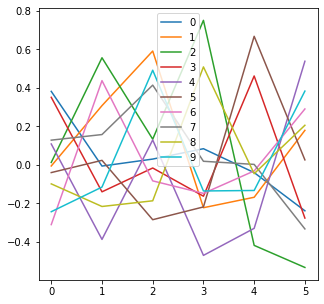

In [19]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

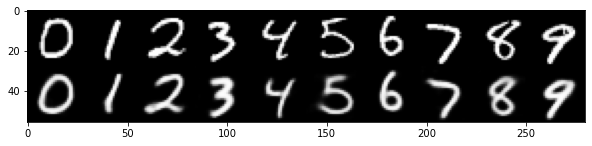

In [20]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [21]:
from XAE.sampler import gaus

exn = 5

In [22]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

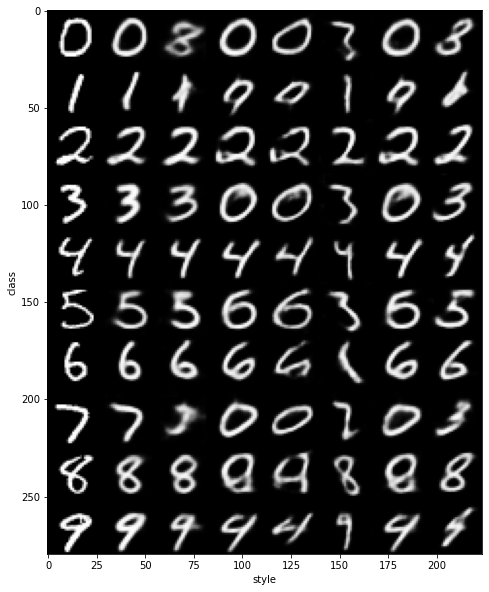

In [23]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [24]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

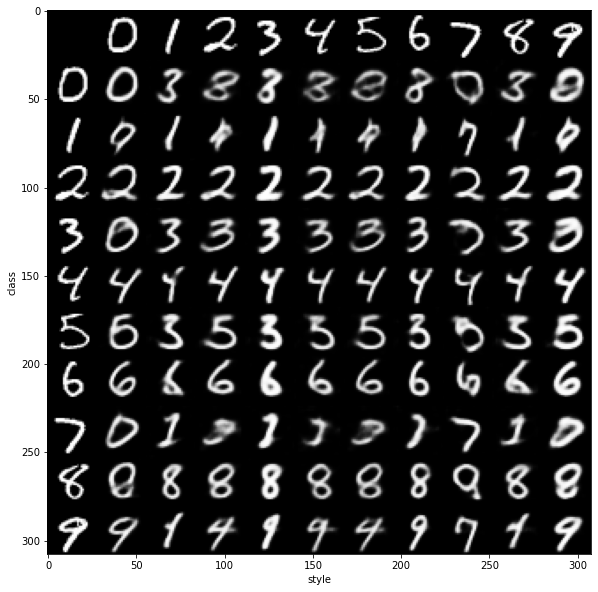

In [25]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()